In [1]:
# NOTE: this is a custom cell that contains the common imports I personally 
# use these may/may not be necessary for the following examples

# DL framework
import tensorflow as tf

from datetime import datetime

# common packages
import numpy as np
import os # handling file i/o
import sys
import math
import time # timing epochs
import random

# for ordered dict when building layer components
import collections

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import colors # making colors consistent
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar helper


# from imageio import imread # read image from disk
# + data augmentation
from scipy import ndimage
from scipy import misc


import pickle # manually saving best params
from sklearn.utils import shuffle # shuffling data batches
from tqdm import tqdm # display training progress bar

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# helper to create dirs if they don't already exist
def maybe_create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("{} created".format(dir_path))
    else:
        print("{} already exists".format(dir_path))
    
def make_standard_dirs(saver=True, best_params=True, tf_logs=True):
    # `saver/` will hold tf saver files
    maybe_create_dir("saver")
    # `best_params/` will hold a serialized version of the best params
    # I like to keep this as a backup in case I run into issues with
    # the saver files
    maybe_create_dir("best_params")
    # `tf_logs/` will hold the logs that will be visable in tensorboard
    maybe_create_dir("tf_logs")

    
# set tf log level to supress messages, unless an error
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Important Version information
print("Python: {}".format(sys.version_info[:]))
print('TensorFlow: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

Python: (3, 5, 4, 'final', 0)
TensorFlow: 1.4.0
Default GPU Device: /device:GPU:0


In [2]:
make_standard_dirs()

saver already exists
best_params already exists
tf_logs already exists


In [3]:
BEST_PARAMS_PATH = "new_best_params"

In [4]:
# these two functions (get_model_params and restore_model_params) are 
# ad[a|o]pted from; 
# https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb
def get_model_params():
    global_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {global_vars.op.name: value for global_vars, value in 
            zip(global_vars, tf.get_default_session().run(global_vars))}

def restore_model_params(model_params, g, sess):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: g.get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    sess.run(assign_ops, feed_dict=feed_dict)

# these two functions are used to manually save the best
# model params to disk
def save_obj(obj, name):
    with open('best_params/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('best_params/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Dataset

In [5]:
ROOT_DATA = "../../ROOT_DATA/"
DATA_DIR = "mnist_data"

MNIST_TRAINING_PATH = os.path.join(ROOT_DATA, DATA_DIR)
# ensure we have the correct directory
for _, _, files in os.walk(MNIST_TRAINING_PATH):
    files = sorted(files)
    for filename in files:
        print(filename)

t10k-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz
train-images-idx3-ubyte.gz
train-labels-idx1-ubyte.gz


In [6]:
from tensorflow.examples.tutorials.mnist import input_data
MNIST = input_data.read_data_sets(MNIST_TRAINING_PATH, one_hot=True)

Extracting ../../ROOT_DATA/mnist_data/train-images-idx3-ubyte.gz
Extracting ../../ROOT_DATA/mnist_data/train-labels-idx1-ubyte.gz
Extracting ../../ROOT_DATA/mnist_data/t10k-images-idx3-ubyte.gz
Extracting ../../ROOT_DATA/mnist_data/t10k-labels-idx1-ubyte.gz


In [8]:
def create_hyper_params():
    data_params = {}
    data_params['n_epochs'] = 50
    data_params['batch_size'] = 128
    data_params['buffer_size'] = 128 # for shuffling

    data_params['init_lr'] = 1e-2

    return data_params

In [9]:
def build_graph(data_params):
    g = tf.Graph()
    n_outputs = 10
    IMG_HEIGHT = 28
    IMG_WIDTH = 28
    CHANNELS = 1
    with g.as_default():
        with tf.name_scope("inputs"):
            X = tf.placeholder(tf.float32, shape=(None, 784), name="data") # Input
            X_reshaped = tf.reshape(X, shape=[-1, IMG_HEIGHT, IMG_WIDTH, CHANNELS])
            y = tf.placeholder(tf.int32, shape=(None, n_outputs), name="labels") # Target

        with tf.name_scope("cnn"):
            h_1 = tf.layers.conv2d(X_reshaped, filters=32, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_1")
            h_2 = tf.layers.conv2d(h_1, filters=64, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_2")
            h_3 = tf.layers.max_pooling2d(h_2, pool_size=[2,2],
                                          strides=2, name="max_pool_01")
            last_shape = int(np.prod(h_3.get_shape()[1:]))
            h_3_flat = tf.reshape(h_3, shape=[-1, last_shape])
            h_4 = tf.layers.dense(h_3_flat, 64, name="layer_04", activation=tf.nn.elu)
            logits = tf.layers.dense(h_4, n_outputs, name="logits")

        with tf.name_scope("loss"):
            xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
            batch_loss = tf.reduce_mean(xentropy, name="loss")
        
        with tf.name_scope("train"):
            optimizer = tf.train.GradientDescentOptimizer(data_params['init_lr'])
            training_op = optimizer.minimize(batch_loss)
            
        with tf.name_scope("save_session"):
            init_global = tf.global_variables_initializer()
            init_local = tf.local_variables_initializer()
            saver = tf.train.Saver()

        # Ops: training metrics
        with tf.name_scope("metrics"):
            # ================================== performance
            with tf.name_scope("common"):
                preds = tf.nn.softmax(logits, name="prediction")
                y_true_cls = tf.argmax(y,1)
                y_pred_cls = tf.argmax(preds,1)
                correct_prediction = tf.equal(y_pred_cls, y_true_cls, name="correct_predictions")
                batch_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            with tf.name_scope("train_metrics") as scope:
                train_auc, train_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                train_acc, train_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                train_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_met_reset_op = tf.variables_initializer(train_acc_vars, name="train_met_reset_op")
            with tf.name_scope("val_metrics") as scope:
                val_auc, val_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                val_acc, val_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                val_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_met_reset_op = tf.variables_initializer(val_acc_vars, name="val_met_reset_op")
            with tf.name_scope("test_metrics") as scope:
                test_auc, test_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                test_acc, test_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                test_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_acc_reset_op = tf.variables_initializer(test_acc_vars, name="test_met_reset_op")

            # =============================================== loss 
            with tf.name_scope("train_loss_eval") as scope:
                train_mean_loss, train_mean_loss_update = tf.metrics.mean(batch_loss)
                train_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_loss_reset_op = tf.variables_initializer(train_loss_vars, name="train_loss_reset_op")
            with tf.name_scope("val_loss_eval") as scope:
                val_mean_loss, val_mean_loss_update = tf.metrics.mean(batch_loss)
                val_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_loss_reset_op = tf.variables_initializer(val_loss_vars, name="val_loss_reset_op")
            with tf.name_scope("test_loss_eval")as scope:
                test_mean_loss, test_mean_loss_update = tf.metrics.mean(batch_loss)
                test_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_loss_reset_op = tf.variables_initializer(test_loss_vars, name="test_loss_rest_op")

        # --- create collections
        for node in (saver, init_global, init_local):
            g.add_to_collection("save_init", node)
        for node in (X, X_reshaped, y, training_op):
            g.add_to_collection("main_ops", node)
        for node in (preds, y_true_cls, y_pred_cls):
            g.add_to_collection("preds", node)
        for node in (train_auc, train_auc_update, train_acc, train_acc_update, train_met_reset_op):
            g.add_to_collection("train_metrics", node)
        for node in (val_auc, val_auc_update, val_acc, val_acc_update, val_met_reset_op):
            g.add_to_collection("val_metrics", node)
        for node in (test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op):
            g.add_to_collection("test_metrics", node)
        for node in (train_mean_loss, train_mean_loss_update, train_loss_reset_op):
            g.add_to_collection("train_loss", node)
        for node in (val_mean_loss, val_mean_loss_update, val_loss_reset_op):
            g.add_to_collection("val_loss", node)
        for node in (test_mean_loss, test_mean_loss_update, test_loss_reset_op):
            g.add_to_collection("test_loss", node)
        g.add_to_collection("logits", logits)
            
        # ===================================== tensorboard
        with tf.name_scope("tensorboard_writer") as scope:
            epoch_train_loss_scalar = tf.summary.scalar('train_epoch_loss', train_mean_loss)
            epoch_train_acc_scalar = tf.summary.scalar('train_epoch_acc', train_acc)
            epoch_train_auc_scalar = tf.summary.scalar('train_epoch_auc', train_auc)
            epoch_train_write_op = tf.summary.merge([epoch_train_loss_scalar, epoch_train_acc_scalar, epoch_train_auc_scalar], name="epoch_train_write_op")

            # ===== epoch, validation
            epoch_validation_loss_scalar = tf.summary.scalar('validation_epoch_loss', val_mean_loss)
            epoch_validation_acc_scalar = tf.summary.scalar('validation_epoch_acc', val_acc)
            epoch_validation_auc_scalar = tf.summary.scalar('validation_epoch_auc', val_auc)
            epoch_validation_write_op = tf.summary.merge([epoch_validation_loss_scalar, epoch_validation_acc_scalar, epoch_validation_auc_scalar], name="epoch_validation_write_op")
        
        for node in (epoch_train_write_op, epoch_validation_write_op):
            g.add_to_collection("tensorboard", node)
            

    return g

In [10]:
def train_graph(g):
    global BEST_PARAMS_PATH
    saver, init_global, init_local = g.get_collection("save_init")
    X, X_reshaped, y, training_op = g.get_collection("main_ops")
    preds, y_true_cls, y_pred_cls = g.get_collection("preds")
    train_auc, train_auc_update, train_acc, train_acc_update, train_met_reset_op = g.get_collection("train_metrics")
    val_auc, val_auc_update, val_acc, val_acc_update, val_met_reset_op = g.get_collection("val_metrics")
    train_mean_loss, train_mean_loss_update, train_loss_reset_op = g.get_collection("train_loss")
    val_mean_loss, val_mean_loss_update, val_loss_reset_op = g.get_collection("val_loss")
    epoch_train_write_op, epoch_validation_write_op = g.get_collection("tensorboard")

    train_writer = tf.summary.FileWriter(os.path.join("tf_logs","train"))
    val_writer = tf.summary.FileWriter(os.path.join("tf_logs","validation"))
    
    best_val_loss = np.inf
    
    with tf.Session(graph=g) as sess:
        sess.run([init_global, init_local])
        
        for e in tqdm(range(1,data_params['n_epochs']+1)):
            sess.run([val_met_reset_op,val_loss_reset_op,train_met_reset_op,train_loss_reset_op])
            
            n_batches = int(MNIST.train.num_examples/data_params['batch_size'])
            for i in range(1, n_batches+1):
                data, target = MNIST.train.next_batch(data_params['batch_size'])
                sess.run([training_op, train_auc_update, train_acc_update, train_mean_loss_update], feed_dict={X:data, y:target})
        
            # write average for epoch
            summary = sess.run(epoch_train_write_op)    
            train_writer.add_summary(summary, e)
            train_writer.flush()

            # run validation
            n_batches = int(MNIST.validation.num_examples/data_params['batch_size'])
            for i in range(1,n_batches+1):
                Xb, yb = MNIST.validation.next_batch(data_params['batch_size'])
                sess.run([val_auc_update, val_acc_update, val_mean_loss_update], feed_dict={X:data, y:target})

            # check for (and save) best validation params here
            cur_loss, cur_acc = sess.run([val_mean_loss, val_acc])
            if cur_loss < best_val_loss:
                best_val_loss = cur_loss
                best_params = get_model_params()
                save_obj(best_params, BEST_PARAMS_PATH)
                print("best params saved: acc: {:.3f}% loss: {:.4f}".format(cur_acc*100, cur_loss))

            summary = sess.run(epoch_validation_write_op) 
            val_writer.add_summary(summary, e)
            val_writer.flush()
        
        train_writer.close()
        val_writer.close()
    return sess

In [11]:
reset_graph()
data_params = create_hyper_params()
g = build_graph(data_params)
sess = train_graph(g)

  2%|▏         | 1/50 [00:05<04:26,  5.43s/it]

best params saved: acc: 95.312% loss: 0.1767


  6%|▌         | 3/50 [00:14<03:43,  4.76s/it]

best params saved: acc: 98.438% loss: 0.0923


 14%|█▍        | 7/50 [00:33<03:27,  4.83s/it]

best params saved: acc: 99.219% loss: 0.0425


 24%|██▍       | 12/50 [00:58<03:05,  4.89s/it]

best params saved: acc: 100.000% loss: 0.0246


 40%|████      | 20/50 [01:35<02:22,  4.75s/it]

best params saved: acc: 100.000% loss: 0.0202


 44%|████▍     | 22/50 [01:45<02:14,  4.80s/it]

best params saved: acc: 100.000% loss: 0.0156


 54%|█████▍    | 27/50 [02:16<01:56,  5.07s/it]

best params saved: acc: 100.000% loss: 0.0095


 58%|█████▊    | 29/50 [02:29<01:48,  5.16s/it]

best params saved: acc: 100.000% loss: 0.0075


 78%|███████▊  | 39/50 [03:19<00:56,  5.12s/it]

best params saved: acc: 100.000% loss: 0.0044


 84%|████████▍ | 42/50 [03:34<00:40,  5.10s/it]

best params saved: acc: 100.000% loss: 0.0029


100%|██████████| 50/50 [04:09<00:00,  4.99s/it]


## Test
This is a checkpoint - in that training can be skipped if previous best params are saved

In [12]:
reset_graph()
data_params = create_hyper_params()
g2 = build_graph(data_params)
best_params = load_obj(BEST_PARAMS_PATH)
with tf.Session(graph=g2) as sess:
    saver, init_global, init_local = g2.get_collection("save_init")
    X, X_reshaped, y, training_op = g2.get_collection("main_ops")
    preds, y_true_cls, y_pred_cls = g2.get_collection("preds")
    test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
    test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
    
    restore_model_params(model_params=best_params, g=g2, sess=sess)
    sess.run([test_acc_reset_op, test_loss_reset_op])
    
    n_batches = int(MNIST.test.num_examples/data_params['batch_size'])
    for i in tqdm(range(n_batches)):
        Xb, yb = MNIST.test.next_batch(data_params['batch_size'])
        batch_accuracy, batch_loss, batch_auc = sess.run([test_acc_update, test_mean_loss_update, test_auc_update], 
                                                                  feed_dict={X:Xb,y:yb})
    # print
    final_test_acc, final_test_loss, final_test_auc = sess.run([test_acc, test_mean_loss, test_auc])
    print("test auc: {:.3f}% acc: {:.3f}% loss: {:.5f}".format(final_test_auc*100, 
                                                              final_test_acc*100,
                                                              final_test_loss))

100%|██████████| 78/78 [00:00<00:00, 106.47it/s]

test auc: 99.906% acc: 98.027% loss: 0.06035


## Obtain Sample Image


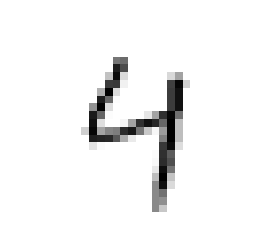

In [13]:
some_idx = 26
some_image = MNIST.test.images[some_idx]
some_label_enc = MNIST.test.labels[some_idx]
some_label_dec = np.argmax(some_label_enc)
some_digit_image = some_image.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

## How does the current architecture classify the image

In [14]:
# this function needs some work, but it currently serves it's purpose
def display_figure_and_prob(img, probs, save_path):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    ax1.imshow(img, cmap = matplotlib.cm.binary,
           interpolation="nearest")
    y_pos = np.arange(10)
    ax2.bar(y_pos, probs, align='center', alpha=0.5)
    plt.title('Confidence')
    plt.grid('off')
    plt.tight_layout()
    save_path = "./output_images/" + save_path + ".png"
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, frameon=False)
    plt.show()

test auc: 100.000% acc: 100.000% loss: 0.00154
true_class: [4]
pred_class [4]
confidence: 99.8460%


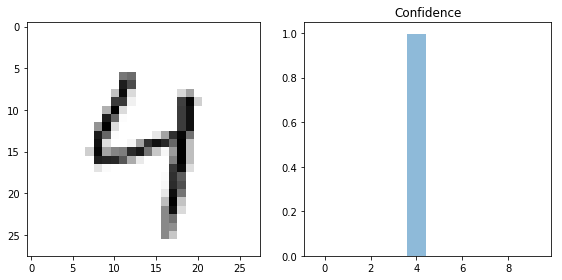

In [15]:
def test_model(img, label):
    reset_graph()
    data_params = create_hyper_params()
    g2 = build_graph(data_params)
    best_params = load_obj(BEST_PARAMS_PATH)
    with tf.Session(graph=g2) as sess:
        saver, init_global, init_local = g2.get_collection("save_init")
        X, X_reshaped, y, training_op = g2.get_collection("main_ops")
        preds, y_true_cls, y_pred_cls = g2.get_collection("preds")
        test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
        test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
        logz = g2.get_collection("logits")[0]

        sess.run([init_global, init_local])

        restore_model_params(model_params=best_params, g=g2, sess=sess)
        sess.run([test_acc_reset_op, test_loss_reset_op])
        Xb, yb = np.expand_dims(img,0), np.expand_dims(label, 0)
        batch_accuracy, batch_loss, batch_auc = sess.run([test_acc_update, test_mean_loss_update, test_auc_update], 
                                                                  feed_dict={X:Xb,y:yb})
        pred_value, true_cls_value, pred_cls_value = sess.run([preds, y_true_cls, y_pred_cls],
                                                              feed_dict={X:Xb,y:yb})
        logits_val = sess.run([logz], feed_dict={X:Xb,y:yb})[0]
        print
        final_test_acc, final_test_loss, final_test_auc = sess.run([test_acc, test_mean_loss, test_auc])
        print("test auc: {:.3f}% acc: {:.3f}% loss: {:.5f}".format(final_test_auc*100, 
                                                                   final_test_acc*100,
                                                                   final_test_loss))
        pred_idx = pred_cls_value[0]
        print("true_class: {}\npred_class {}".format(true_cls_value, pred_cls_value))
        
        confidence = pred_value[0][pred_idx]*100
        print("confidence: {:.4f}%".format(confidence))

        jack = np.argmax(pred_value[0])
        name = "mnist_" + str(jack) + "_conf_" + str(confidence)
        display_figure_and_prob(some_digit_image, pred_value[0], name)
        
    return pred_idx, confidence
        
pred_label, pred_confidence = test_model(some_image, some_label_enc)

In [18]:
def build_adv_graph(data_params):
    g = tf.Graph()
    n_outputs = 10
    IMG_HEIGHT = 28
    IMG_WIDTH = 28
    CHANNELS = 1
    with g.as_default():
        with tf.name_scope("inputs"):
            #X = tf.placeholder(tf.float32, shape=(None, 784), name="data") # Input
            #X_reshaped = tf.reshape(X, shape=[-1, IMG_HEIGHT, IMG_WIDTH, CHANNELS])
            Xx = tf.Variable(tf.zeros((28, 28, 1)))
            Xxx = tf.expand_dims(Xx, 0)
            y = tf.placeholder(tf.int32, shape=(None, n_outputs), name="labels") # Target

        with tf.name_scope("cnn"):
            h_1 = tf.layers.conv2d(Xxx, filters=32, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_1")
            h_2 = tf.layers.conv2d(h_1, filters=64, kernel_size=3, activation=tf.nn.elu,
                                   padding='SAME', strides=1, name="conv_2")
            h_3 = tf.layers.max_pooling2d(h_2, pool_size=[2,2],
                                          strides=2, name="max_pool_01")
            last_shape = int(np.prod(h_3.get_shape()[1:]))
            h_3_flat = tf.reshape(h_3, shape=[-1, last_shape])
            h_4 = tf.layers.dense(h_3_flat, 64, name="layer_04", activation=tf.nn.elu)
            logits = tf.layers.dense(h_4, n_outputs, name="logits")

        with tf.name_scope("loss"):
            xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
            batch_loss = tf.reduce_mean(xentropy, name="loss")
        
        with tf.name_scope("train"):
            optimizer = tf.train.GradientDescentOptimizer(data_params['init_lr'])
            training_op = optimizer.minimize(batch_loss)
            
        with tf.name_scope("save_session"):
            init_global = tf.global_variables_initializer()
            init_local = tf.local_variables_initializer()
            saver = tf.train.Saver()
        
        with tf.name_scope("adv"):
            x = tf.placeholder(tf.float32, (28, 28, 1), name="jack") # Input
            x_hat = Xx
            assign_op = tf.assign(x_hat, x)

            y_hat = tf.placeholder(tf.int32, ())
            labels = tf.one_hot(y_hat, 10)
            loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels, name="adv_loss")
            optim_step = tf.train.GradientDescentOptimizer(1e-1).minimize(loss, var_list=[Xx])
            
            epsilon = tf.placeholder(tf.float32, ())
            below = x - epsilon
            above = x + epsilon
            projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)

            with tf.control_dependencies([projected]):
                project_step = tf.assign(x_hat, projected)
                
            for node in (assign_op, x, optim_step, loss, y_hat, epsilon, x_hat, project_step):
                g.add_to_collection("adv", node)

        # Ops: training metrics
        with tf.name_scope("metrics"):
            # ================================== performance
            with tf.name_scope("common"):
                preds = tf.nn.softmax(logits, name="prediction")
                y_true_cls = tf.argmax(y,1)
                y_pred_cls = tf.argmax(preds,1)
                correct_prediction = tf.equal(y_pred_cls, y_true_cls, name="correct_predictions")
                batch_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            with tf.name_scope("train_metrics") as scope:
                train_auc, train_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                train_acc, train_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                train_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_met_reset_op = tf.variables_initializer(train_acc_vars, name="train_met_reset_op")
            with tf.name_scope("val_metrics") as scope:
                val_auc, val_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                val_acc, val_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                val_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_met_reset_op = tf.variables_initializer(val_acc_vars, name="val_met_reset_op")
            with tf.name_scope("test_metrics") as scope:
                test_auc, test_auc_update = tf.metrics.auc(labels=y, predictions=preds)
                test_acc, test_acc_update = tf.metrics.accuracy(labels=y_true_cls, predictions=y_pred_cls)
                test_acc_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_acc_reset_op = tf.variables_initializer(test_acc_vars, name="test_met_reset_op")

            # =============================================== loss 
            with tf.name_scope("train_loss_eval") as scope:
                train_mean_loss, train_mean_loss_update = tf.metrics.mean(batch_loss)
                train_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                train_loss_reset_op = tf.variables_initializer(train_loss_vars, name="train_loss_reset_op")
            with tf.name_scope("val_loss_eval") as scope:
                val_mean_loss, val_mean_loss_update = tf.metrics.mean(batch_loss)
                val_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                val_loss_reset_op = tf.variables_initializer(val_loss_vars, name="val_loss_reset_op")
            with tf.name_scope("test_loss_eval")as scope:
                test_mean_loss, test_mean_loss_update = tf.metrics.mean(batch_loss)
                test_loss_vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
                test_loss_reset_op = tf.variables_initializer(test_loss_vars, name="test_loss_rest_op")

        # --- create collections
        for node in (saver, init_global, init_local):
            g.add_to_collection("save_init", node)
        for node in (X, Xx, y, training_op):
            g.add_to_collection("main_ops", node)
        for node in (preds, y_true_cls, y_pred_cls):
            g.add_to_collection("preds", node)
        for node in (train_auc, train_auc_update, train_acc, train_acc_update, train_met_reset_op):
            g.add_to_collection("train_metrics", node)
        for node in (val_auc, val_auc_update, val_acc, val_acc_update, val_met_reset_op):
            g.add_to_collection("val_metrics", node)
        for node in (test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op):
            g.add_to_collection("test_metrics", node)
        for node in (train_mean_loss, train_mean_loss_update, train_loss_reset_op):
            g.add_to_collection("train_loss", node)
        for node in (val_mean_loss, val_mean_loss_update, val_loss_reset_op):
            g.add_to_collection("val_loss", node)
        for node in (test_mean_loss, test_mean_loss_update, test_loss_reset_op):
            g.add_to_collection("test_loss", node)
        g.add_to_collection("logits", logits)
            
        # ===================================== tensorboard
        with tf.name_scope("tensorboard_writer") as scope:
            epoch_train_loss_scalar = tf.summary.scalar('train_epoch_loss', train_mean_loss)
            epoch_train_acc_scalar = tf.summary.scalar('train_epoch_acc', train_acc)
            epoch_train_auc_scalar = tf.summary.scalar('train_epoch_auc', train_auc)
            epoch_train_write_op = tf.summary.merge([epoch_train_loss_scalar, epoch_train_acc_scalar, epoch_train_auc_scalar], name="epoch_train_write_op")

            # ===== epoch, validation
            epoch_validation_loss_scalar = tf.summary.scalar('validation_epoch_loss', val_mean_loss)
            epoch_validation_acc_scalar = tf.summary.scalar('validation_epoch_acc', val_acc)
            epoch_validation_auc_scalar = tf.summary.scalar('validation_epoch_auc', val_auc)
            epoch_validation_write_op = tf.summary.merge([epoch_validation_loss_scalar, epoch_validation_acc_scalar, epoch_validation_auc_scalar], name="epoch_validation_write_op")
        
        for node in (epoch_train_write_op, epoch_validation_write_op):
            g.add_to_collection("tensorboard", node)
            
    return g

In [19]:
def produce_targeted_adv_image(img, adv_target=0,adv_eps=0.07,adv_lr=1e-1,adv_steps=50000):
    
    #TODO: learning rate is currently hardcoded
    reset_graph()
    data_params = create_hyper_params()
    g3 = build_adv_graph(data_params)
    best_params = load_obj(BEST_PARAMS_PATH)
    with tf.Session(graph=g3) as sess:
        saver, init_global, init_local = g3.get_collection("save_init")
        X, Xx, y, training_op = g3.get_collection("main_ops")
        preds, y_true_cls, y_pred_cls = g3.get_collection("preds")
        test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g3.get_collection("test_metrics")
        test_mean_loss, test_mean_loss_update, test_loss_reset_op = g3.get_collection("test_loss")
        logz = g3.get_collection("logits")[0]

        sess.run([init_global, init_local])

        restore_model_params(model_params=best_params, g=g3, sess=sess)
        sess.run([test_acc_reset_op, test_loss_reset_op])

        # execution
        assign_op, x, optim_step, loss, y_hat, epsilon, x_hat, project_step = g3.get_collection("adv")

        # initialization step
        sess.run(assign_op, feed_dict={x: img})

        # projected gradient descent
        for i in tqdm(range(1, adv_steps+1)):
            # gradient descent step
            _, loss_value = sess.run(
                [optim_step, loss],
                feed_dict={y_hat: adv_target})
            # project step
            sess.run(project_step, feed_dict={x: img, epsilon: adv_eps})
            if (i+1) % 1000 == 0:
                print('step %d, loss=%g' % (i+1, loss_value))

        adv_out = x_hat.eval() # retrieve the adversarial example
        
    return adv_out
adv_out = produce_targeted_adv_image(some_image.reshape(28,28,1), adv_target=9)
adv_flat = adv_out.reshape((784))

  2%|▏         | 1068/50000 [00:02<02:00, 406.34it/s]

step 1000, loss=0.22078


  4%|▍         | 2049/50000 [00:04<01:54, 419.36it/s]

step 2000, loss=0.220718


  6%|▌         | 3069/50000 [00:07<01:51, 422.29it/s]

step 3000, loss=0.220721


  8%|▊         | 4083/50000 [00:09<01:48, 423.12it/s]

step 4000, loss=0.220731


 10%|█         | 5058/50000 [00:12<01:48, 414.27it/s]

step 5000, loss=0.220786


 12%|█▏        | 6068/50000 [00:14<01:46, 412.27it/s]

step 6000, loss=0.220713


 14%|█▍        | 7066/50000 [00:17<01:44, 411.74it/s]

step 7000, loss=0.220715


 16%|█▌        | 8042/50000 [00:19<01:41, 411.73it/s]

step 8000, loss=0.220738


 18%|█▊        | 9063/50000 [00:22<01:39, 410.01it/s]

step 9000, loss=0.220715


 20%|██        | 10043/50000 [00:25<01:39, 399.70it/s]

step 10000, loss=0.220735


 22%|██▏       | 11081/50000 [00:27<01:37, 398.41it/s]

step 11000, loss=0.220757


 24%|██▍       | 12078/50000 [00:30<01:34, 400.23it/s]

step 12000, loss=0.220729


 26%|██▌       | 13015/50000 [00:32<01:33, 395.93it/s]

step 13000, loss=0.220763


 28%|██▊       | 14040/50000 [00:35<01:31, 393.20it/s]

step 14000, loss=0.220733


 30%|███       | 15058/50000 [00:38<01:28, 394.13it/s]

step 15000, loss=0.220762


 32%|███▏      | 16067/50000 [00:40<01:26, 392.84it/s]

step 16000, loss=0.220747


 34%|███▍      | 17043/50000 [00:44<01:26, 382.13it/s]

step 17000, loss=0.220762


 36%|███▌      | 18040/50000 [00:48<01:25, 373.86it/s]

step 18000, loss=0.22072


 38%|███▊      | 19035/50000 [00:51<01:23, 370.60it/s]

step 19000, loss=0.220764


 40%|████      | 20044/50000 [00:55<01:22, 363.77it/s]

step 20000, loss=0.220763


 42%|████▏     | 21053/50000 [00:58<01:20, 358.66it/s]

step 21000, loss=0.220782


 44%|████▍     | 22046/50000 [01:01<01:17, 361.07it/s]

step 22000, loss=0.220764


 46%|████▌     | 23046/50000 [01:03<01:14, 363.24it/s]

step 23000, loss=0.220794


 48%|████▊     | 24053/50000 [01:05<01:10, 365.45it/s]

step 24000, loss=0.220723


 50%|█████     | 25045/50000 [01:08<01:08, 366.38it/s]

step 25000, loss=0.220794


 52%|█████▏    | 26051/50000 [01:10<01:05, 367.70it/s]

step 26000, loss=0.220722


 54%|█████▍    | 27048/50000 [01:13<01:02, 369.07it/s]

step 27000, loss=0.220734


 56%|█████▌    | 28058/50000 [01:15<00:59, 370.24it/s]

step 28000, loss=0.220716


 58%|█████▊    | 29063/50000 [01:18<00:56, 371.16it/s]

step 29000, loss=0.220777


 60%|██████    | 30039/50000 [01:20<00:53, 372.30it/s]

step 30000, loss=0.220772


 62%|██████▏   | 31057/50000 [01:23<00:50, 372.60it/s]

step 31000, loss=0.220701


 64%|██████▍   | 32055/50000 [01:26<00:48, 372.56it/s]

step 32000, loss=0.220762


 66%|██████▌   | 33072/50000 [01:28<00:45, 372.87it/s]

step 33000, loss=0.220743


 68%|██████▊   | 34044/50000 [01:31<00:42, 372.93it/s]

step 34000, loss=0.220721


 70%|███████   | 35030/50000 [01:34<00:40, 370.41it/s]

step 35000, loss=0.220747


 72%|███████▏  | 36022/50000 [01:38<00:38, 365.38it/s]

step 36000, loss=0.220718


 74%|███████▍  | 37022/50000 [01:42<00:35, 362.92it/s]

step 37000, loss=0.220748


 76%|███████▌  | 38056/50000 [01:46<00:33, 358.73it/s]

step 38000, loss=0.220723


 78%|███████▊  | 39030/50000 [01:49<00:30, 356.56it/s]

step 39000, loss=0.220711


 80%|████████  | 40054/50000 [01:52<00:27, 355.37it/s]

step 40000, loss=0.220718


 82%|████████▏ | 41048/50000 [01:55<00:25, 356.30it/s]

step 41000, loss=0.220726


 84%|████████▍ | 42082/50000 [01:57<00:22, 357.24it/s]

step 42000, loss=0.220724


 86%|████████▌ | 43064/50000 [02:00<00:19, 358.34it/s]

step 43000, loss=0.220739


 88%|████████▊ | 44057/50000 [02:02<00:16, 359.41it/s]

step 44000, loss=0.220728


 90%|█████████ | 45061/50000 [02:05<00:13, 360.22it/s]

step 45000, loss=0.220733


 92%|█████████▏| 46077/50000 [02:07<00:10, 361.12it/s]

step 46000, loss=0.220773


 94%|█████████▍| 47059/50000 [02:10<00:08, 361.53it/s]

step 47000, loss=0.220719


 96%|█████████▌| 48036/50000 [02:13<00:05, 359.29it/s]

step 48000, loss=0.220738


 98%|█████████▊| 49068/50000 [02:17<00:02, 357.93it/s]

step 49000, loss=0.220737


100%|██████████| 50000/50000 [02:19<00:00, 358.09it/s]

step 50000, loss=0.220737


test auc: 88.889% acc: 0.000% loss: 1.70378
true_class: [4]
pred_class [9]
confidence: 80.1897%


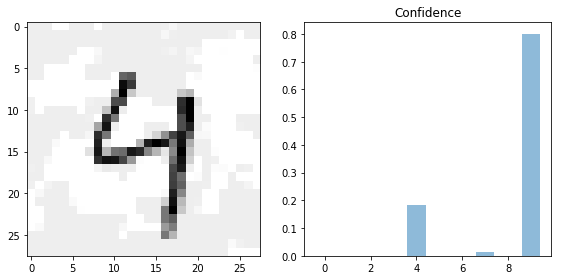

In [20]:
def test_adversarial(img, label):
    reset_graph()
    data_params = create_hyper_params()
    g2 = build_graph(data_params)
    best_params = load_obj(BEST_PARAMS_PATH)
    with tf.Session(graph=g2) as sess:
        saver, init_global, init_local = g2.get_collection("save_init")
        X, X_reshaped, y, training_op = g2.get_collection("main_ops")
        preds, y_true_cls, y_pred_cls = g2.get_collection("preds")
        test_auc, test_auc_update, test_acc, test_acc_update, test_acc_reset_op = g2.get_collection("test_metrics")
        test_mean_loss, test_mean_loss_update, test_loss_reset_op = g2.get_collection("test_loss")
        logz = g2.get_collection("logits")[0]

        sess.run([init_global, init_local])

        restore_model_params(model_params=best_params, g=g2, sess=sess)
        sess.run([test_acc_reset_op, test_loss_reset_op])
        Xb, yb = np.expand_dims(img,0), np.expand_dims(label, 0)
        batch_accuracy, batch_loss, batch_auc = sess.run([test_acc_update, test_mean_loss_update, test_auc_update], 
                                                                  feed_dict={X:Xb,y:yb})
        pred_value, true_cls_value, pred_cls_value = sess.run([preds, y_true_cls, y_pred_cls],
                                                              feed_dict={X:Xb,y:yb})
        logits_val = sess.run([logz], feed_dict={X:Xb,y:yb})[0]

        final_test_acc, final_test_loss, final_test_auc = sess.run([test_acc, test_mean_loss, test_auc])
        print("test auc: {:.3f}% acc: {:.3f}% loss: {:.5f}".format(final_test_auc*100, 
                                                                   final_test_acc*100,
                                                                   final_test_loss))
        pred_idx = pred_cls_value[0]
        print("true_class: {}\npred_class {}".format(true_cls_value, pred_cls_value))
        confidence = pred_value[0][pred_idx]*100
        print("confidence: {:.4f}%".format(confidence))

        jack = np.argmax(pred_value[0])
        name = "mnist_" + str(jack) + "_conf_" + str(confidence) + "_adv"
        display_figure_and_prob(adv_flat.reshape(28, 28), pred_value[0], name)

    return pred_idx, confidence

a_pred_label, a_pred_confidence = test_adversarial(adv_flat, some_label_enc)

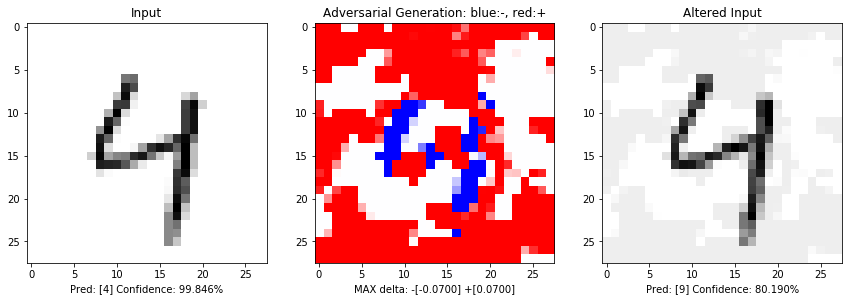

In [21]:
def plot_adv_array(img, adv, pred_label, pred_confidence, 
                   a_pred_label, a_pred_confidence):
    diff = adv - some_digit_image
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax1.imshow(img, cmap = matplotlib.cm.binary,
                   interpolation="nearest")
    cmapx = plt.get_cmap('bwr')
    ax1.set_title("Input")
    ax1.set_xlabel("Pred: [{}] Confidence: {:.3f}%".format(pred_label, pred_confidence))
    ax2.imshow(diff, cmap = cmapx,
                   interpolation="nearest")
    ax2.set_title("Adversarial Generation: blue:-, red:+")
    ax2.set_xlabel("MAX delta: -[{:.4f}] +[{:.4f}]".format(np.min(diff), np.max(diff)))
    ax3.imshow(adv, cmap = matplotlib.cm.binary,
                   interpolation="nearest")
    ax3.set_title("Altered Input")
    ax3.set_xlabel("Pred: [{}] Confidence: {:.3f}%".format(a_pred_label, a_pred_confidence))
    plt.grid('off')
    plt.tight_layout()
    name = "./output_images/" + "adv_array_" + str(pred_label) + "_to_" + str(a_pred_label) + ".png"
    plt.savefig(name, bbox_inches='tight', pad_inches=0, frameon=False)
    plt.show()

plot_adv_array(some_digit_image, adv_flat.reshape(28, 28), pred_label, pred_confidence, a_pred_label, a_pred_confidence)